# Lab 4: Пошук ознак у зображенні. Детектування границь/вершин областей
### Шевченко Юлія, ФІ-31мн

For this homework assignment, we will delve into the implementation of a lane line detector—a critical component of Advanced Driver Assistance Systems (ADAS), specifically Lane Keep Assist (LKA). Leveraging an image captured from a front-facing camera mounted on a vehicle, we will undertake the following steps:

#### 1. Convert Image to Gray Scale
The initial step involves converting the input image into grayscale. Grayscale conversion simplifies subsequent edge detection and Hough transform operations by reducing the image to a single channel of intensity values.

#### 2. Compute Edge Map
Using edge detection techniques such as the Canny edge detector or Sobel operator, compute an edge map highlighting regions of significant intensity variation within the grayscale image. This step is pivotal in isolating potential lane lines from the background.

#### 3. Apply Hough Transform for Line Parametrization
Employ the Hough transform algorithm to identify lines within the edge map. The Hough transform enables the detection of lines by representing them in parametric form (typically slope-intercept or polar coordinates). By transforming each edge point into a parameter space, it becomes possible to identify lines that correspond to significant accumulations of intersecting points.

#### Additional Considerations:
- **Parameter Tuning**: Fine-tuning parameters such as edge detection thresholds and Hough transform parameters (e.g., accumulator resolution, minimum line length, maximum gap) is crucial for achieving optimal results.
- **Region of Interest (ROI) Masking**: Limiting edge detection and Hough transform operations to a region of interest (typically the area where lane lines are expected) can enhance efficiency and accuracy.
- **Post-processing**: Post-processing steps such as line filtering, smoothing, or extrapolation may be necessary to refine detected lane lines and improve robustness.
- **Visualization**: Visualize the detected lane lines overlaid on the original image to assess performance and validate results.

Lane line detection is a fundamental task in autonomous driving systems, aiding in lane tracking, lane departure warning, and autonomous navigation. By implementing these steps effectively, we will gain valuable insights into the foundational techniques used in computer vision for real-world applications in automotive safety and autonomy.


In [1]:
# All the imports for the task
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

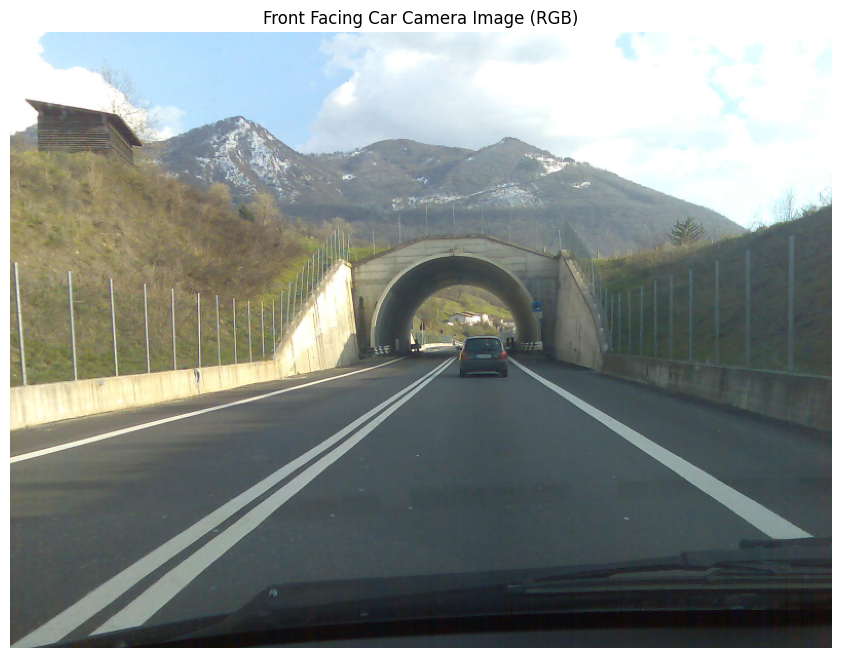

In [2]:
# Loading the test image
image_path = '../Lab_4/dashcam.jpg'
img = cv2.imread(image_path)

# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize image
img = cv2.resize(img, None, fx=0.5, fy=0.5)

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.title('Front Facing Car Camera Image (RGB)')
plt.axis('off')
plt.show()

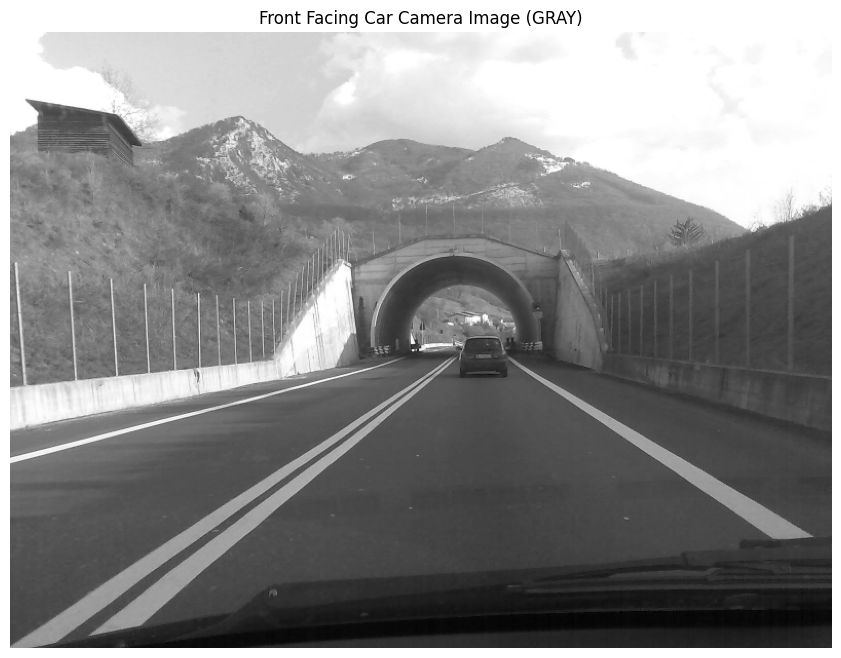

In [3]:
# Convert image to gray scale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Plot the gray image
plt.figure(figsize=(12, 8))
plt.imshow(img_gray, cmap='gray')
plt.title('Front Facing Car Camera Image (GRAY)')
plt.axis('off')
plt.show()

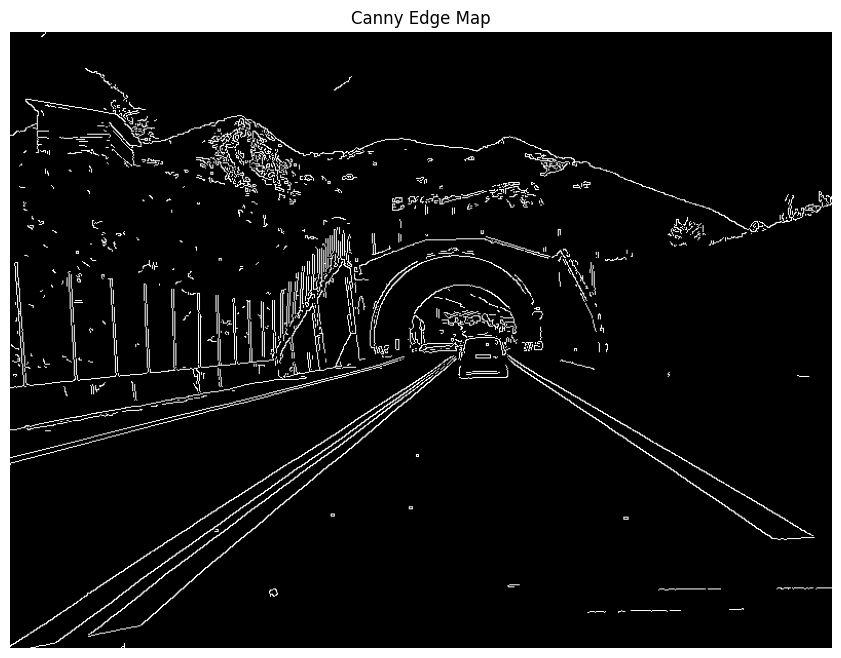

In [4]:
# Obtain an edge map using Canny edge detector
edges = cv2.Canny(img_gray, threshold1=100, threshold2=150)

# Plot the edge map
plt.figure(figsize=(12, 8))
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Map')
plt.axis('off')
plt.show()

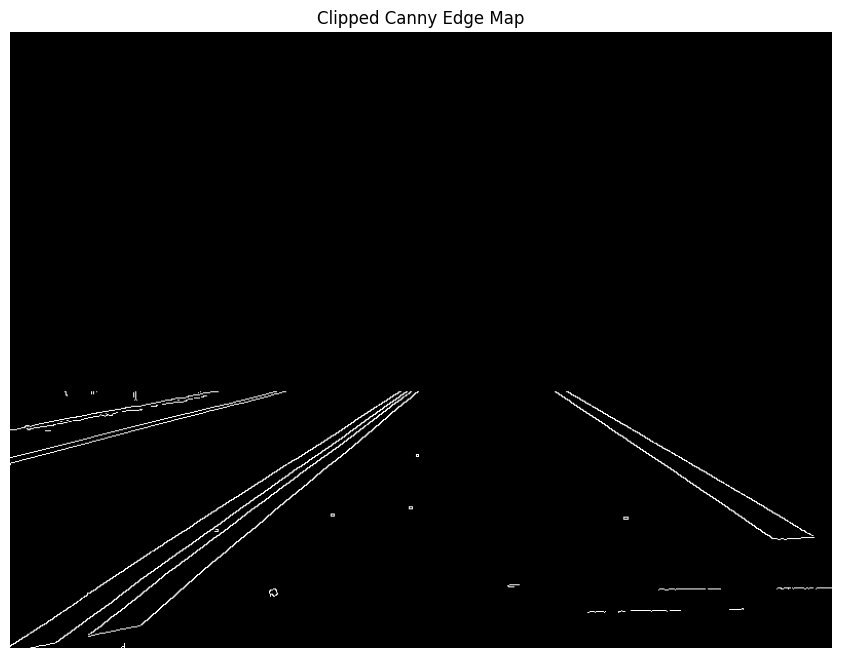

In [5]:
# Remove everything above the horizon (we are only interested in the road)
edges[0:350, :] = 0

# Plot the edge map
plt.figure(figsize=(12, 8))
plt.imshow(edges, cmap='gray')
plt.title('Clipped Canny Edge Map')
plt.axis('off')
plt.show()

In [6]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLinesP(edges, rho=2, theta=np.pi/180*2, threshold=190, minLineLength=50, maxLineGap=10)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

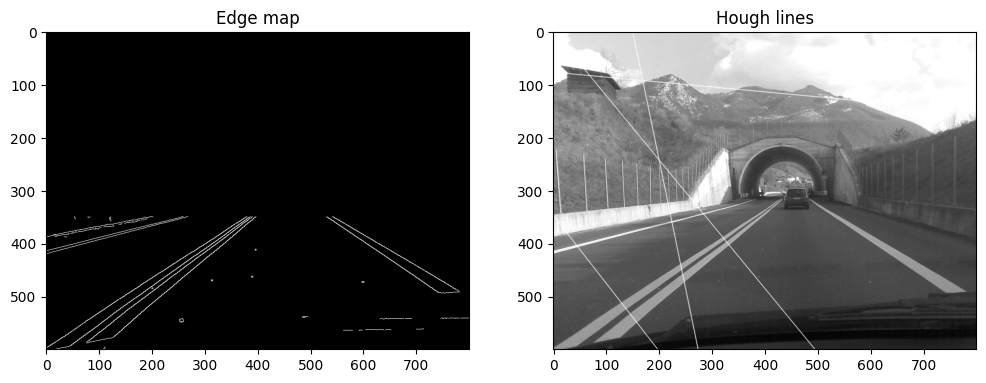

In [7]:
# Plot the resulting Hough lines
result = np.copy(img_gray)
        
for line in lines:
    rho, theta = line[0], line[1]
    
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, (255, 0, 0), 1, cv2.LINE_AA)

plt.figure(figsize=(12, 8))
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')
plt.show()

The edge map looks good, but the Hough lines are too noisy. Let’s clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [8]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees).
filtered_lines = []
for line in lines:
    # Extract rho and theta for current line
    x1, y1, x2, y2 = line
    theta = np.arctan2(y2 - y1, x2 - x1)
    
    # Keep line if theta is not horizontal
    if np.abs(theta - np.pi/2) > np.deg2rad(20):
        filtered_lines.append(line)

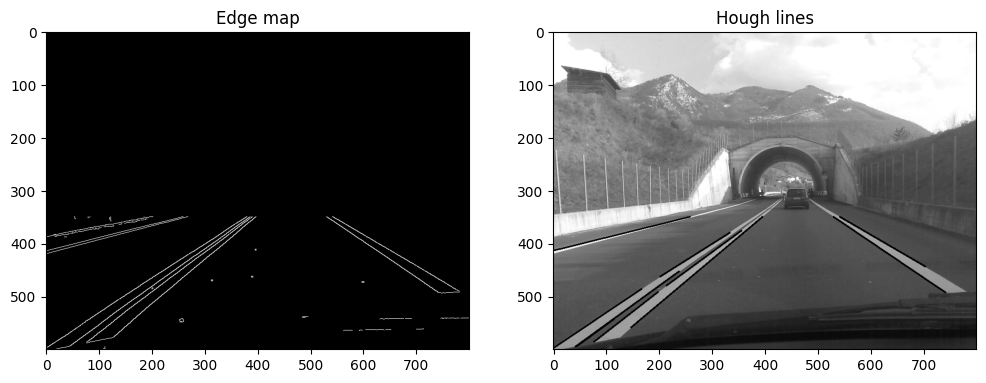

In [9]:
# Let's plot the resulting filtered lines
result = np.copy(img_gray)

for line in filtered_lines:
    x1, y1, x2, y2 = line
    
    # Calculate rho and theta if needed
    theta = np.arctan2(y2 - y1, x2 - x1)
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    
    # Draw the line on the result image
    cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')
plt.show()

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the six we see in the picture lines and use the averages.

In [10]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[ 39.66666667, 593.        , 201.        , 477.        ],
       [536.        , 350.        , 723.        , 468.5       ],
       [147.        , 559.        , 396.        , 350.        ],
       [208.        , 471.5       , 345.        , 378.        ],
       [  0.        , 414.        , 259.        , 350.        ],
       [ 45.        , 594.        , 115.        , 543.        ]])

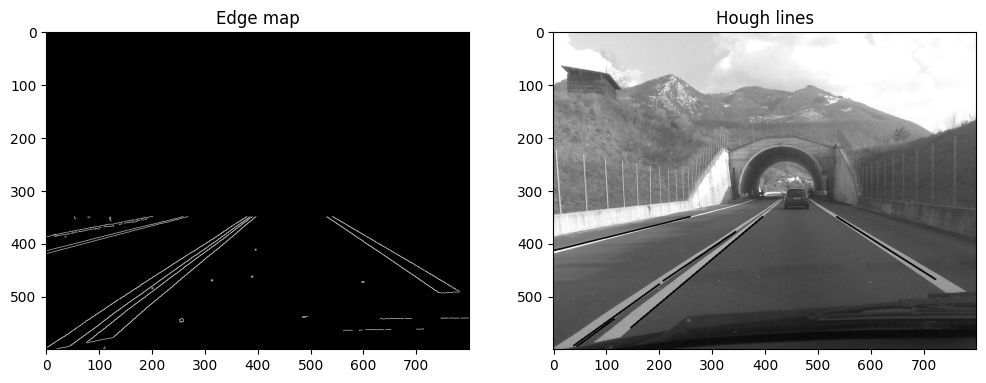

In [11]:
# Again, let's plot the resulting filtered lines
result = np.copy(img_gray)

for line in kmeans.cluster_centers_:
    # Unpack the coordinates of the line
    x1, y1, x2, y2 = line
    
    # Draw the line on the result image
    cv2.line(result, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')
plt.show()


## Lane Line Detector Questions

**Do you see anything strange in the final result?**

In the final result, one aspect that might appear unusual is the presence of discontinuities or gaps in the detected lane lines. These gaps could arise due to various factors such as noisy input data, imperfect edge detection, or limitations in the Hough transform parameters. Additionally, unexpected artifacts or spurious lines may appear in the output, especially if the Hough transform parameters are not appropriately tuned or if the input image contains complex background elements that interfere with lane detection.

**Do you think the Hough transform resolution is important for obtaining a good result? Why?**

Yes, the Hough transform resolution is crucial for obtaining accurate and reliable results in lane detection. The resolution determines the granularity of the parameter space in which lines are detected. Higher resolution allows for finer discrimination of line parameters, enabling the detection of subtle lane markings and reducing the risk of false positives or missed detections. Conversely, low resolution may lead to coarse parameter estimation, resulting in inaccurate line detection and diminished overall performance of the lane detection algorithm.

**Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?**

Absolutely, the Hough transform accumulator threshold significantly impacts the quality and reliability of the detected lines. This threshold determines the minimum number of votes required for a line to be considered valid and included in the output. Setting a higher accumulator threshold helps filter out spurious or noisy detections, leading to a cleaner set of detected lines with reduced false positives. However, setting the threshold too high may result in genuine lane lines being discarded, leading to missed detections. Conversely, a lower threshold increases sensitivity to weaker line detections but may also increase the likelihood of false positives. Therefore, careful selection of the accumulator threshold is essential to balance between robustness and sensitivity in lane detection.